In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

#mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
#read in data
# wine = pd.read_csv('drive/My Drive/ML Project-SEIS 763/wine_reviews.csv', encoding='latin-1')

wine = pd.read_csv('wine_reviews.csv', encoding='latin-1')

In [0]:
# drop columns
wine = wine.drop(columns=['Unnamed: 0', 'region_1', 'region_2', 'taster_twitter_handle', 'designation'])

In [0]:
# drop duplicates
wine = wine.drop_duplicates('description')
wine.shape

(119955, 9)

In [0]:
average = wine['price'].mean()
print(average)

med = wine['price'].median()
print(med)
q = wine.quantile([.25, .75])
print(q)

35.62054191651653
25.0
      points  price
0.25    86.0   17.0
0.75    91.0   42.0


In [0]:
# drop outliers for price
# change price column from float to integer
wine = wine[wine['price'] < 100]
wine.astype({'price': 'int64'})
wine.shape

(107782, 9)

In [0]:
# drop missing values
wine.isnull().sum()


country           55
description        0
points             0
price              0
province          55
taster_name    22450
title              0
variety            1
winery             0
dtype: int64

In [0]:
# impute mean for price
wine['price'] = wine['price'].fillna(wine['price'].mean())
wine.isnull().sum()


country           55
description        0
points             0
price              0
province          55
taster_name    22450
title              0
variety            1
winery             0
dtype: int64

In [0]:
wine['taster_name'] = wine['taster_name'].fillna('unknown')
wine.isnull().sum()

country        55
description     0
points          0
price           0
province       55
taster_name     0
title           0
variety         1
winery          0
dtype: int64

In [0]:
wine.dropna(inplace=True)
wine.shape

(107726, 9)

In [0]:
# add vintage column
#wine[['vintage']] = wine.title.str.extract(r'(\d{4})', expand=True)


#wine=wine.astype({'vintage': int})
#wine.shape

In [0]:
wine.head(2)

,country,description,points,price,province,taster_name,title,variety,winery
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [0]:
# #write function to simplify points to make more useful for machine learning
# def simplify_points(points):
#     if points <= 84:
#         return 1
#     elif points >=85 and points <=89:
#         return 2
#     elif points >=90 and points <=94:
#         return 3
#     else:
#         return 4
    
    
# wine = wine.assign(points_simplified = wine['points'].apply(simplify_points))
# wine.sample(5)

def simplify_points(points):
  if points <= 90:
    return 0
  elif points >=91:
    return 1

wine = wine.assign(points_simplified = wine['points'].apply(simplify_points))
wine.sample(5)

,country,description,points,price,province,taster_name,title,variety,winery,points_simplified
103803,US,"An enticing, heavy-duty blend of 40% Viognier,...",88,30.0,Virginia,unknown,Tarara 2010 Honah Lee White White (Virginia),White Blend,Tarara,0
24192,US,"A barrel selection, the Suzanne's Reserve is m...",87,40.0,Oregon,Paul Gregutt,Left Coast Cellars 2004 Suzanne's Estate Reser...,Pinot Noir,Left Coast Cellars,0
84757,Argentina,"Dark, concentrated, mildly charred aromas of b...",89,15.0,Mendoza Province,Michael Schachner,Lamadrid 2013 Single Vineyard Malbec (Agrelo),Malbec,Lamadrid,0
47217,US,"Here is a big, friendly wine with plenty of sw...",89,13.0,California,Jim Gordon,Peirano 2012 The Heritage Collection Old Vine ...,Zinfandel,Peirano,0
8678,Austria,"Fresh, pliable, slightly pear and apple scente...",88,16.0,NiederÌ¦sterreich,Anne KrebiehlåÊMW,Laurenz V. 2015 Singing Laurenz V. und Sophie ...,GrÌ_ner Veltliner,Laurenz V.,0


0    81602
1    26124
Name: points_simplified, dtype: int64

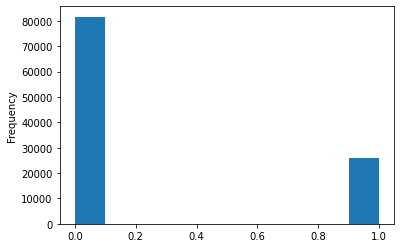

In [0]:
ax = wine['points_simplified'].plot.hist(by='points_simplified')
wine['points_simplified'].value_counts()

Classes appear imbalanced. Needs to be addressed before running model.

In [0]:
# add description length
wine = wine.assign(description_length = wine['description'].apply(len))

In [0]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Text cleaning. Remove punctuation, numbers from description. Make lower case.
import re
def  clean_text(wine, description, description_clean):
    wine['description_clean'] = wine['description'].str.lower()
    wine['description_clean'] = wine['description_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    wine['description_clean'] = wine['description_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return wine
  
wine = clean_text(wine, 'description', 'description_clean')

In [0]:
# remove stopwords
stop = stopwords.words('english')
wine['description_clean'] = wine['description_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
wine.head(3)


,country,description,points,price,province,taster_name,title,variety,winery,points_simplified,description_length,description_clean
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0,227,ripe fruity wine smooth still structured firm ...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0,186,tart snappy flavors lime flesh rind dominate g...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0,199,pineapple rind lemon pith orange blossom start...


In [0]:
#tokenize

# nltk.download('punkt')
# wine['description_tokens'] = wine['description_clean'].apply(lambda x: word_tokenize(x))

In [0]:
#lemmatization
# nltk.download('wordnet')

# def word_lemmatizer(text):
#     lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
#     return lem_text

# wine['description_tokens_lemma'] = wine['description_tokens'].apply(lambda x: word_lemmatizer(x))
# wine['description_tokens_lemma'] = wine['description_tokens_lemma'].astype(str)


In [0]:
# downsample the majority class, points_simplified 0
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = wine[wine.points_simplified==0]
df_minority = wine[wine.points_simplified==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=26124,     # to match minority class
                                 random_state=1)  # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.points_simplified.value_counts()



# # downsample the majority classes
# from sklearn.utils import resample
# # Separate majority and minority classes
# df_1 = wine[wine.points_simplified==1]
# df_2 = wine[wine.points_simplified==2]
# df_3 = wine[wine.points_simplified==3]
# df_4 = wine[wine.points_simplified==4]
 
# # Downsample majority class
# df_majority_1 = resample(df_1, 
#                          replace=False,    # sample without replacement
#                          n_samples=1281,     # to match minority class
#                          random_state=1)  # reproducible results
                    
# df_majority_2 = resample(df_2, 
#                          replace=False,    # sample without replacement
#                          n_samples=1281,     # to match minority class
#                          random_state=1)  # reproducible results 
# df_majority_3 = resample(df_3, 
#                          replace=False,    # sample without replacement
#                          n_samples=1281,     # to match minority class
#                          random_state=1)  # reproducible results                          

# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([df_majority_1, df_majority_2, df_majority_3, df_4])
 
# # Display new class counts
# df_downsampled.points_simplified.value_counts()

1    26124
0    26124
Name: points_simplified, dtype: int64

In [0]:
#import packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [0]:
cv = CountVectorizer(ngram_range=(1,2), analyzer='word', max_df=.85, max_features=3000, lowercase=True, stop_words='english', strip_accents='unicode')
X = cv.fit_transform(df_downsampled['description_clean']+' '+df_downsampled['variety']+' '+df_downsampled['province']+' '+df_downsampled['winery']+' '+df_downsampled['taster_name']+' '+df_downsampled['country'])

y = df_downsampled['points_simplified'].values #target

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [0]:
classifiers = [
    LogisticRegression(class_weight='balanced', multi_class='auto', max_iter=100, n_jobs=None, penalty='l2',
                   solver='lbfgs'),
    KNeighborsClassifier(8),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(n_estimators=80, criterion='entropy', class_weight='balanced'),
    MultinomialNB(),
    SVC(kernel="rbf")
    ]

# Fit models, then return model accuracy
for classifier in classifiers:
    model = classifier.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % model.score(X_test, y_test))

In [0]:
# GridSearch CV logistic regression
penalty_options = ['l1', 'l2']
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = dict(dual=dual,max_iter=max_iter,C=C, penalty=penalty_options, solver=solver_options)

lr = LogisticRegression()
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.828281 using {'C': 1.0, 'dual': False, 'max_iter': 140, 'penalty': 'l1', 'solver': 'liblinear'}


In [0]:
#Random Forest
rf=RandomForestClassifier(n_estimators=50, criterion='entropy', bootstrap=False)
rf.fit(X_train, y_train)
print("model score: %.3f" % rf.score(X_test, y_test))

model score: 0.816


In [0]:
#GridSearchCV for random forest
grid_param = {  
    'n_estimators': [50, 60, 70, 80, 90],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

gd_sr = GridSearchCV(estimator=rf, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_train, y_train) 
print("Best: %f using %s" % (gd_sr.best_score_, gd_sr.best_params_))

Best: 0.816235 using {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 90}


In [0]:
# GridSearchCV on SVM

svc=SVC()
svc.fit(X_train, y_train)

#GridCV for SVC
grid_param = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

grid = GridSearchCV(estimator=svc, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(X_train, y_train) 
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
# Randomized Search CV on SVM

svc=SVC()
svc.fit(X_train, y_train)

#RandomizedCV for SVC
grid_param = {
    'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

grid = RandomizedSearchCV(estimator=svc, param_distributions=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
grid.fit(X_train, y_train) 
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))


Best: 0.832743 using {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}


In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, random_state=7)
result = cross_val_score(rf, X, y, cv=kfold, scoring='accuracy')
print(result.mean())
print(result.std())